In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
from comet_ml import Experiment

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
sns.set_theme()

from ift6758.models.utils import preprocess, predict_model,save_metrics_and_models_on_comet,compute_metrics
from ift6758.models.plotter import *
from dotenv import load_dotenv

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import time

from comet_ml import API

from sklearn.linear_model import LogisticRegression


In [2]:
url = 'https://drive.google.com/file/d/1kM__riNHRPx5GsyuOH3yhiql3OZvwmuP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

In [3]:
df_train = df[df['season']!=20192020]

## question 5.1

In [4]:
# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = ['distance','angle'], standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True, stratify=Y)

# define and train model
model = XGBClassifier()

# fit_model
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/princesslove/itf-6758-team-4/da3d1de95f164994a69ecd8be274747f

COMET WARNING: Converting metric value ''question5.1'' into a string using str(), resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/da3d1de95f164994a69ecd8be274747f
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.5013013732212985
COMET INFO:     Accuracy   : 0.906195174756436
COMET INFO:     Precision  : 0.6976589257949748
COMET INFO:     Recall     : 0.5013013732212985
COMET INFO:     f_score    : 0.4782889055761102
COMET INFO:   

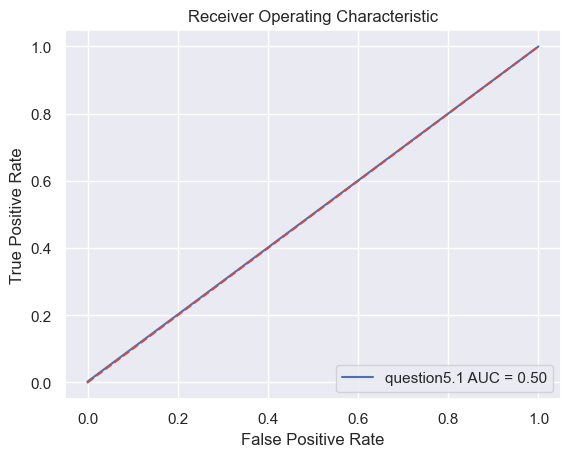

<Figure size 640x480 with 0 Axes>

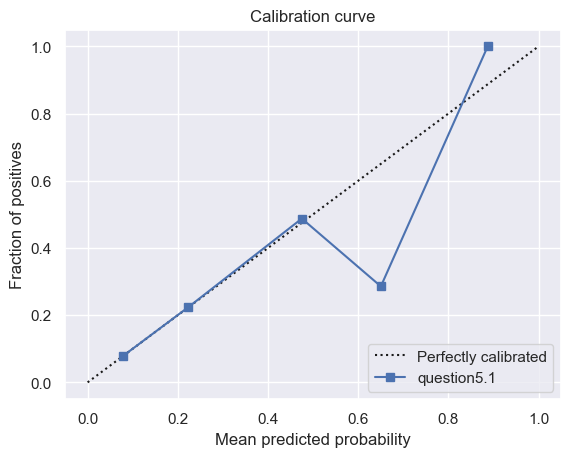

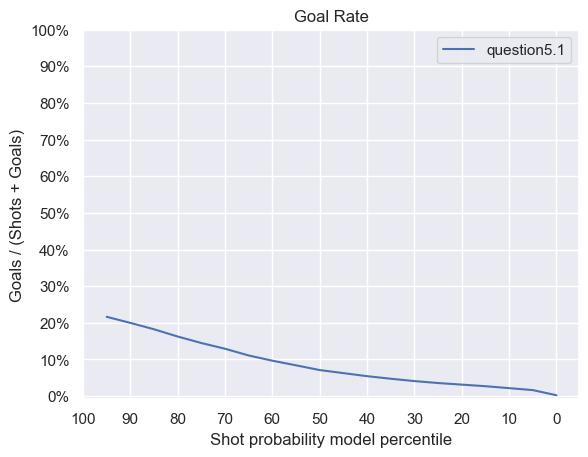

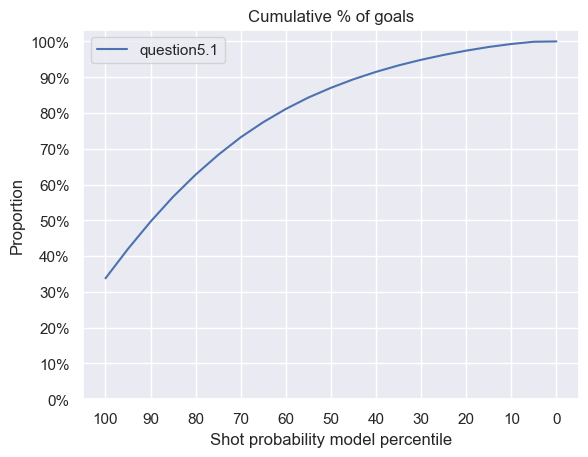

In [5]:
name_experiment = "question5.1"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = False)

## question 5.2

In [4]:
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)



In [21]:
# define and train model
model = XGBClassifier()
 
# fit_model
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

df_metrics_results = compute_metrics(y_val,[y_val_pred],model_names=['XGB'])
df_metrics_results

,model_name,Accuracy,Recall,Precision,f_score
0,XGB,0.911135,0.532808,0.866628,0.538652


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/6449640d1b1948048f02c1e1bc50bc5d
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.5328081064498501
COMET INFO:     Accuracy   : 0.9111348903184063
COMET INFO:     Precision  : 0.8666281698314976
COMET INFO:     Recall     : 0.5328081064498501
COMET INFO:     f_score    : 0.5386519305832189
COMET INFO:     model_name : question5.2_without_grid_search
COMET INFO:   Others:
COMET INFO:     Name : question5.2_without_grid_search
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     confusion-matrix             : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures  

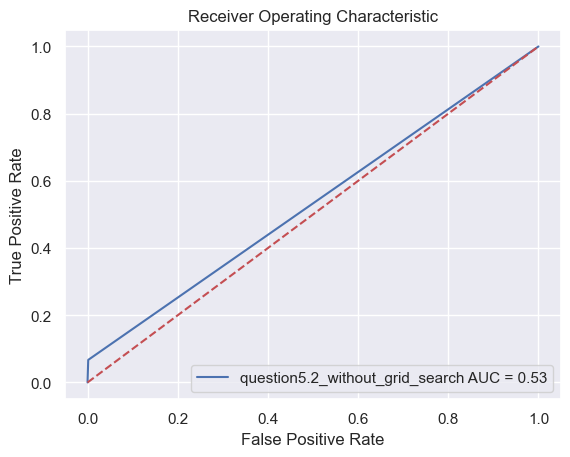

<Figure size 640x480 with 0 Axes>

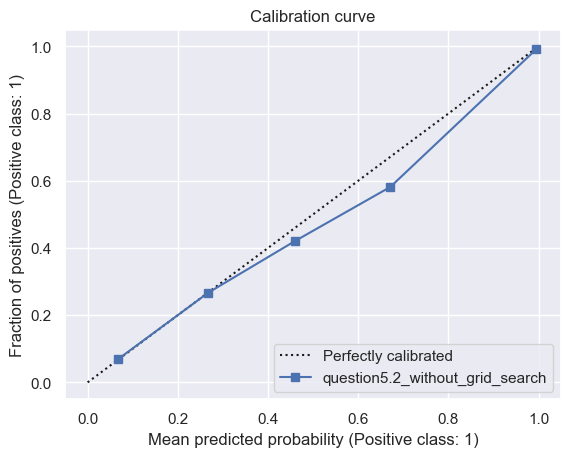

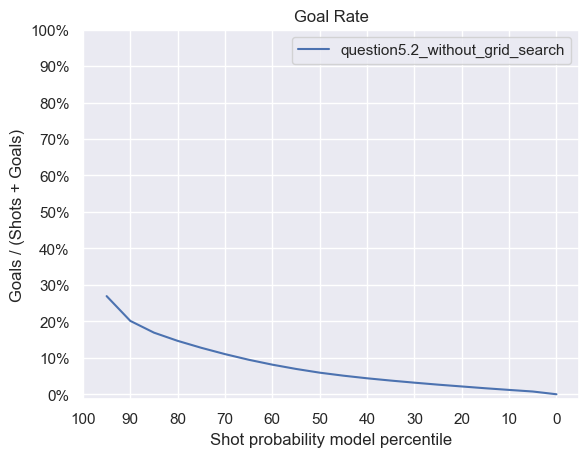

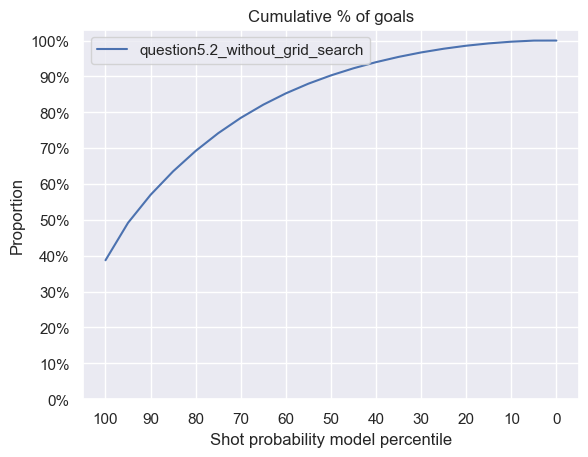

In [23]:
name_experiment = "question5.2_without_grid_search"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = False )

## question 5.2 Performing Cross Validation Grid Search with all features

In [5]:
#setting grid of selected parameters for iteration

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
              'scale_pos_weight' : [2,3,4,5,6,7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'max_delta_step' : [1,2,3,4,5,6,7,8,9,10],
              'min_child_weight': [1, 5, 10],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'lambda':[0.4, 0.6,0.8,1],
            'alpha':[0, 0.2,0.4,0.6],
            }

In [6]:
# question 5.2

list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)

# define and train model
model = XGBClassifier(objective='binary:logistic',
                        predictor='cpu_predictor',
                        tree_method = 'hist')

# performing Random Search
folds = 5
param_comb = 100



skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
#rskf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=3, random_state = 42)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb, scoring='f1_macro', n_jobs=-1, cv=skf, verbose=3, random_state=42 )

# Here we go
start_time = time.time() # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
print(time.time() - start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 2/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2, reg_lambda=0, scale_pos_weight=6, subsample=0.8;, score=0.620 total time= 1.2min
[CV 3/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2, reg_lambda=0, scale_pos_weight=6, subsample=0.8;, score=0.613 total time= 1.2min
[CV 4/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2, reg_lambda=0, scale_pos_weight=6, subsample=0.8;, score=0.618 total time= 1.2min
[CV 1/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2

/Users/salhilamia/opt/anaconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END alpha=0.4, colsample_bytree=1.0, gamma=0.2, lambda=0.8, learning_rate=0.3, max_delta_step=5, max_depth=7, min_child_weight=1, n_estimators=130, reg_alpha=0.2, reg_lambda=200, scale_pos_weight=4, subsample=1.0;, score=0.618 total time=  10.6s
[CV 4/5] END alpha=0.4, colsample_bytree=1.0, gamma=0.2, lambda=0.8, learning_rate=0.3, max_delta_step=5, max_depth=7, min_child_weight=1, n_estimators=130, reg_alpha=0.2, reg_lambda=200, scale_pos_weight=4, subsample=1.0;, score=0.629 total time=  10.1s
[CV 5/5] END alpha=0.4, colsample_bytree=0.8, gamma=0, lambda=0.8, learning_rate=0.1, max_delta_step=9, max_depth=12, min_child_weight=1, n_estimators=130, reg_alpha=0.1, reg_lambda=200, scale_pos_weight=6, subsample=0.6;, score=0.608 total time=  23.2s
[CV 5/5] END alpha=0.4, colsample_bytree=1.0, gamma=0.2, lambda=0.8, learning_rate=0.3, max_delta_step=5, max_depth=7, min_child_weight=1, n_estimators=130, reg_alpha=0.2, reg_lambda=200, scale_pos_weight=4, subsample=1.0;, score=0.624 

In [7]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
#print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results


 All results:
{'mean_fit_time': array([66.07486224, 25.33797741, 23.00759134, 22.4464437 ,  9.67239785,
       22.18323507,  9.86179466, 15.05788312, 10.1143012 , 14.0193315 ,
       10.46047235, 11.03309479,  9.09685717, 13.32335644, 13.17427111,
        7.50105724, 16.26821651, 16.60593162,  8.62654018, 16.34378819,
       14.89043159, 56.29694285,  6.34593735,  9.64855738,  6.06055336,
       11.82644405,  8.83032784,  8.27960401, 10.58436928,  8.69114437,
        7.91494765, 16.59582853, 12.52509899,  9.70645542, 12.15074992,
        6.87221045,  9.23896718, 13.98857288,  8.69387751, 14.57386203,
       27.67080917, 16.50818605, 31.68328142, 26.9038002 , 12.4782248 ,
       20.41501198, 16.73198481, 19.10997691, 16.19811664, 13.26909533,
       18.9137166 , 19.35361824,  8.39029598, 14.09239521,  6.58322048,
        6.50354624, 12.17022815, 11.2080976 ,  8.62673898,  9.48656611,
        7.87083755, 11.39283352,  8.07735538, 14.88094931,  6.66961703,
        5.56194086, 14.5071106 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,...,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,66.074862,2.340454,5.044183,0.993490,0.8,6,0,0.2,100,5,...,0.6,"{'subsample': 0.8, 'scale_pos_weight': 6, 'reg...",0.609252,0.619851,0.613386,0.618462,0.614545,0.615099,0.003777,24
1,25.337977,0.900426,1.833290,0.162401,0.8,3,0,12.8,100,10,...,0,"{'subsample': 0.8, 'scale_pos_weight': 3, 'reg...",0.615627,0.616806,0.610935,0.621497,0.616093,0.616192,0.003361,22
2,23.007591,5.227678,1.544398,0.349268,0.8,2,0.4,0,100,5,...,0.6,"{'subsample': 0.8, 'scale_pos_weight': 2, 'reg...",0.581242,0.586734,0.584773,0.585556,0.584202,0.584501,0.001838,85
3,22.446444,2.558867,1.293564,0.037944,1.0,6,25.6,0.8,130,10,...,0,"{'subsample': 1.0, 'scale_pos_weight': 6, 'reg...",0.607580,0.614661,0.612456,0.614035,0.610527,0.611852,0.002570,37
4,9.672398,0.448452,0.471703,0.017242,0.8,2,51.2,0.1,130,1,...,0.4,"{'subsample': 0.8, 'scale_pos_weight': 2, 'reg...",0.588586,0.590459,0.585778,0.591360,0.588383,0.588913,0.001929,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11.880569,0.063180,0.901417,0.022007,0.6,6,25.6,0,50,1,...,0.6,"{'subsample': 0.6, 'scale_pos_weight': 6, 'reg...",0.607679,0.616096,0.611929,0.613528,0.611630,0.612172,0.002748,35
96,22.640682,0.095400,1.952358,0.133657,0.8,6,51.2,1.6,100,1,...,0.4,"{'subsample': 0.8, 'scale_pos_weight': 6, 'reg...",0.596495,0.598366,0.600180,0.605135,0.600584,0.600152,0.002884,66
97,20.932171,0.371979,1.738884,0.176032,0.8,2,6.4,0.1,130,10,...,0.2,"{'subsample': 0.8, 'scale_pos_weight': 2, 'reg...",0.582893,0.583792,0.583309,0.586607,0.583371,0.583994,0.001337,86
98,6.674867,0.158737,0.350626,0.048997,1.0,5,6.4,0,150,1,...,0,"{'subsample': 1.0, 'scale_pos_weight': 5, 'reg...",0.614302,0.621693,0.617115,0.623606,0.619491,0.619241,0.003287,15


In [8]:
random_search.best_params_

{'subsample': 1.0,
 'scale_pos_weight': 4,
 'reg_lambda': 102.4,
 'reg_alpha': 0.2,
 'n_estimators': 150,
 'min_child_weight': 5,
 'max_depth': 14,
 'max_delta_step': 10,
 'learning_rate': 0.1,
 'lambda': 0.4,
 'gamma': 3.2,
 'colsample_bytree': 1.0,
 'alpha': 0.4}

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/princesslove/itf-6758-team-4/93f37095918649eea592e37100e8f278

COMET WARNING: Converting metric value ''question5.2_with_grid_search.json'' into a string using str(), resulting string might be invalid
COMET INFO: Successfully registered 'question5-2-with-grid-search-json-model', version '1.0.0' in workspace 'princesslove'


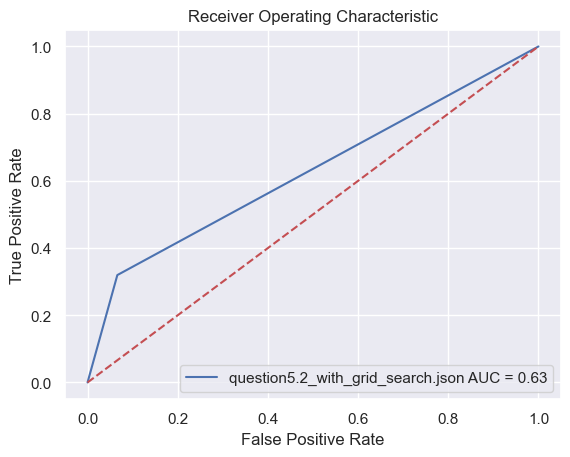

<Figure size 640x480 with 0 Axes>

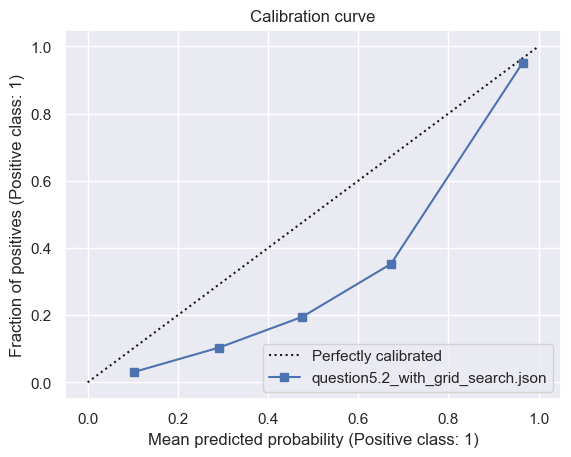

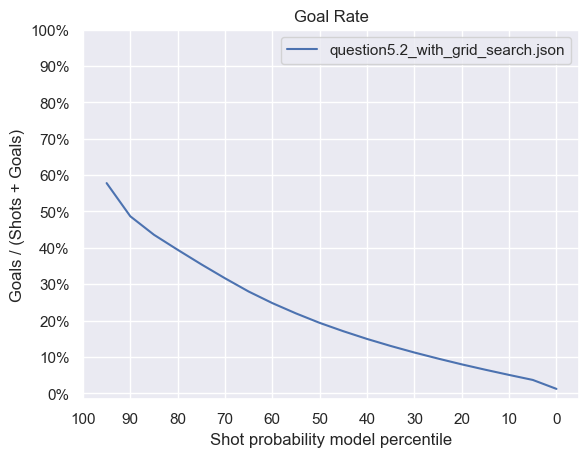

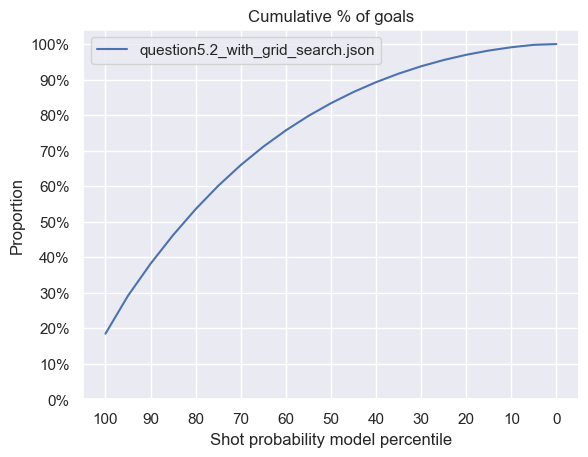

In [9]:
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)

# define and train model
model = XGBClassifier(objective='binary:logistic',
                        predictor='cpu_predictor',
                        tree_method = 'hist')
                        
model.set_params(**random_search.best_params_)
# fit model 
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

name_experiment = "question5.2_with_grid_search"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = True)

## Question 5.3 (features selection)

In [4]:
# list of features (here all of them)
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed,df_train_flag =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)

# concatenate the features and the target in one dataaframe
df_train_total = pd.concat([df_train_preprocessed, pd.DataFrame(Y,columns=['result_event'])], axis=1)

# defining model which will be used for feature selction if necessary
experiment_name = 'question5.2_with_grid_search'

model_xgb_wit_grid_search = XGBClassifier()
model_xgb_wit_grid_search.load_model(f"../models_config/XGB/{experiment_name}.json")

### Explore imbalancement and categorical features balanement

<AxesSubplot: ylabel='count'>

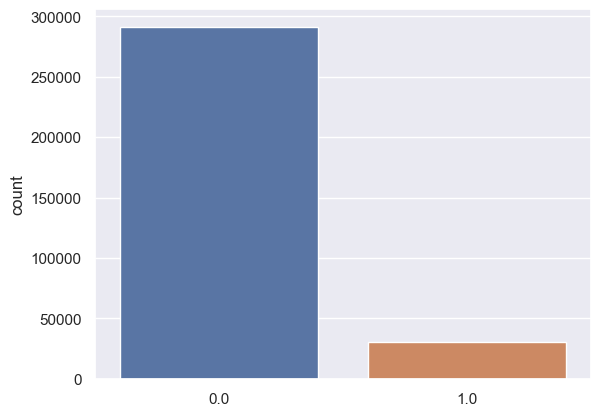

In [5]:
# Count of each labels
sns.countplot(x=Y)

We can see that the data is really imbalanced, for now we solve that by stratifying the train/validation split and by also computing stratified cross validation. Also we set the argument scale_pos_weight of the XGboost model  to  "np.sum(y_train)/len(y_train)".

The imbalancement problem should be handle for the more advanced model of question 6.

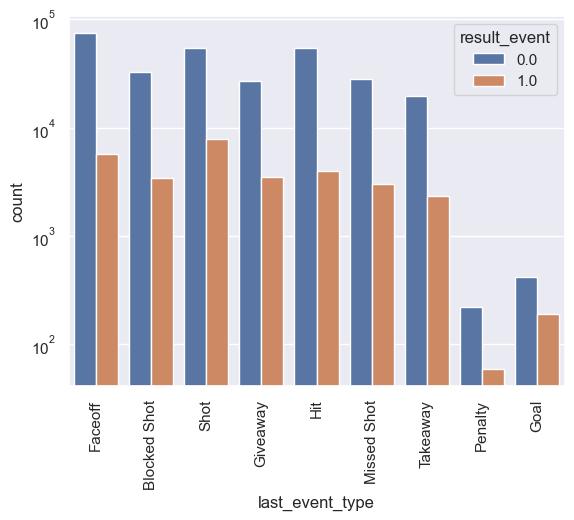

In [6]:
# looking at the last_event_type depending on the target
lest_event_count = sns.countplot(x='last_event_type', hue='result_event', data=df_train_flag,log=True)
loc, labels = plt.xticks()
_ = lest_event_count.set_xticklabels(labels, rotation=90)

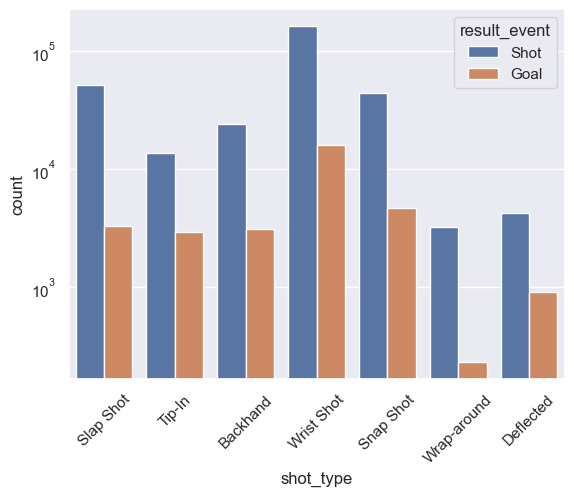

In [7]:
# looking at the shot_type depending on the target
shot_type_count = sns.countplot(x='shot_type', hue='result_event', data=df_train,log=True)
loc, labels = plt.xticks()
_ = shot_type_count.set_xticklabels(labels, rotation=45)

### Exploring XGboost feature importance with SHAP

In [8]:
import xgboost
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model_xgb_wit_grid_search)
shap_values = explainer(df_train_preprocessed[:10000])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


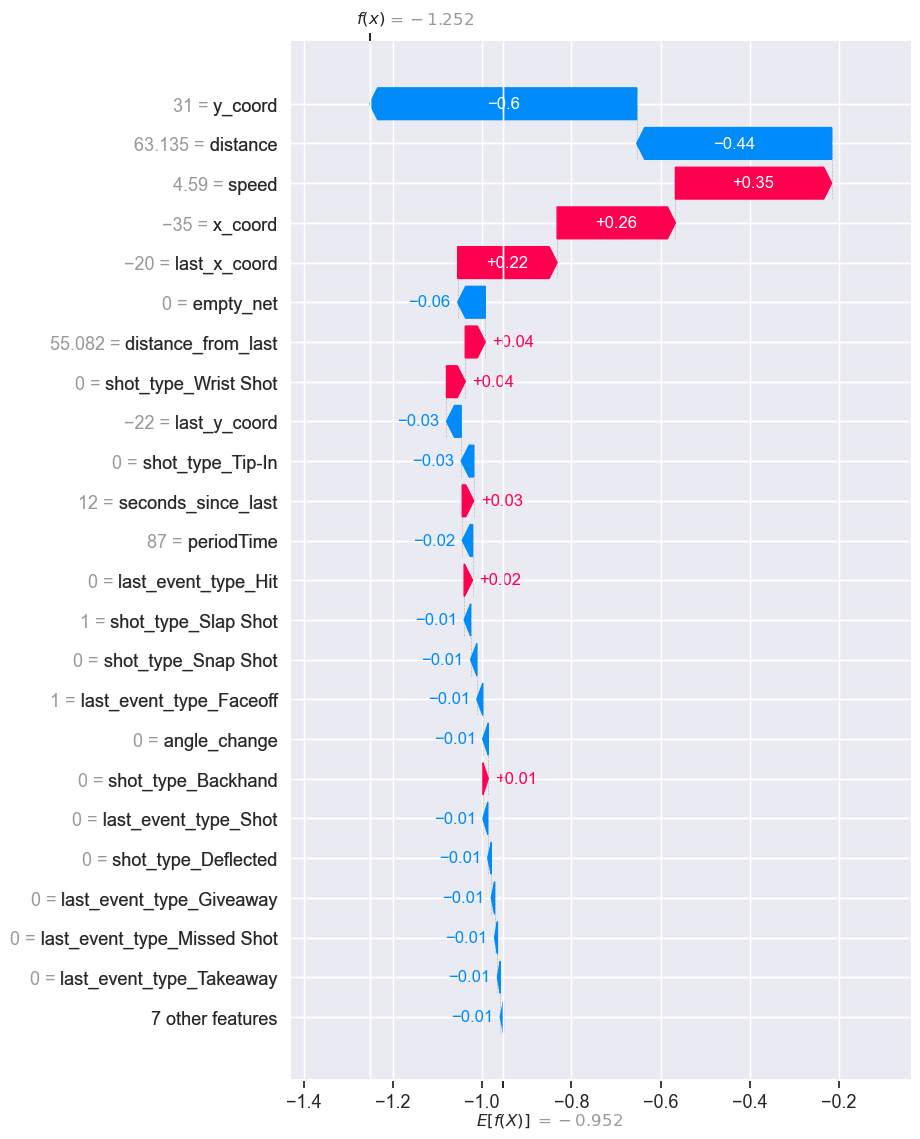

In [9]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=24)

In [10]:
shap_fts_selected = ['y_coord','distance','speed','x_coord',\
    'last_x_coord','empty_net','distance_from_last','shot_type_Wrist Shot','period', 'periodTime',\
        ,'seconds_since_last','shot_type_Tip-In']

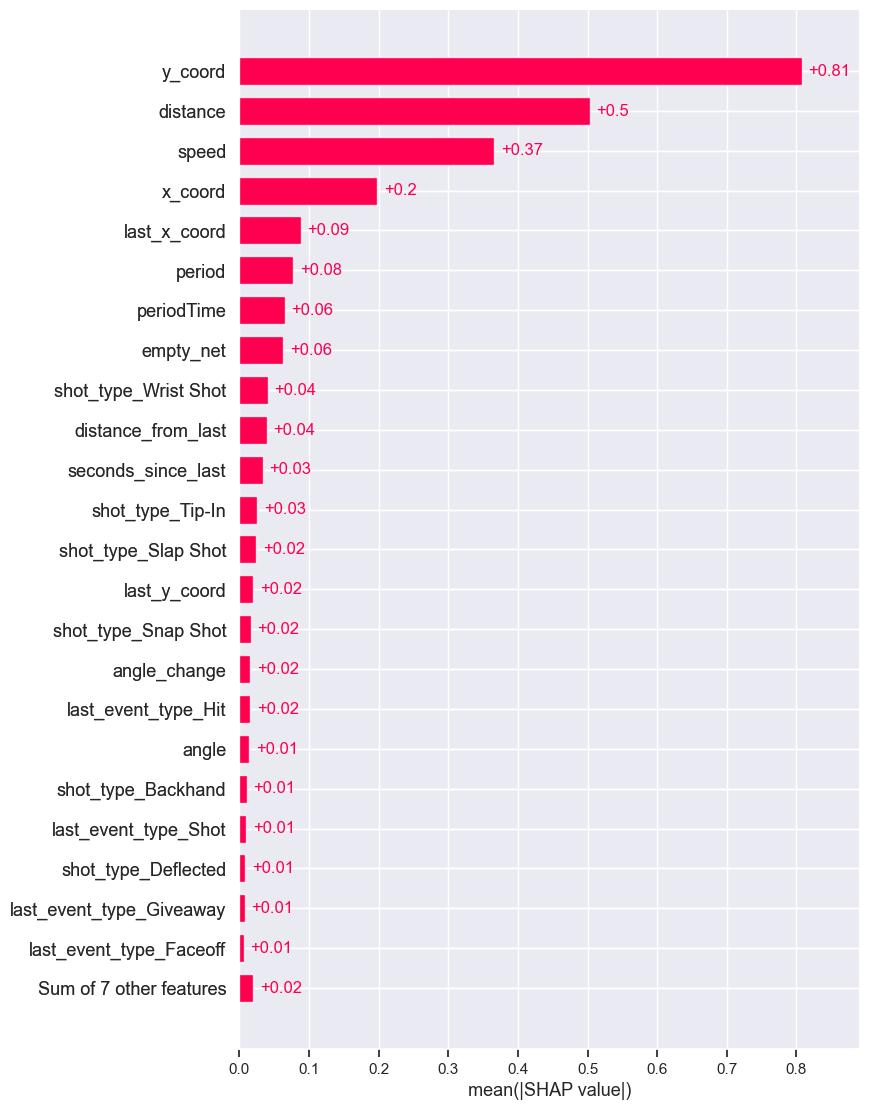

In [11]:
shap.plots.bar(shap_values, max_display=24)

### Exploring Features correlation through a heatmap

We first check the correlation between all features to check for the redundancies between all the features. Thus we can suppress some features.

<AxesSubplot: >

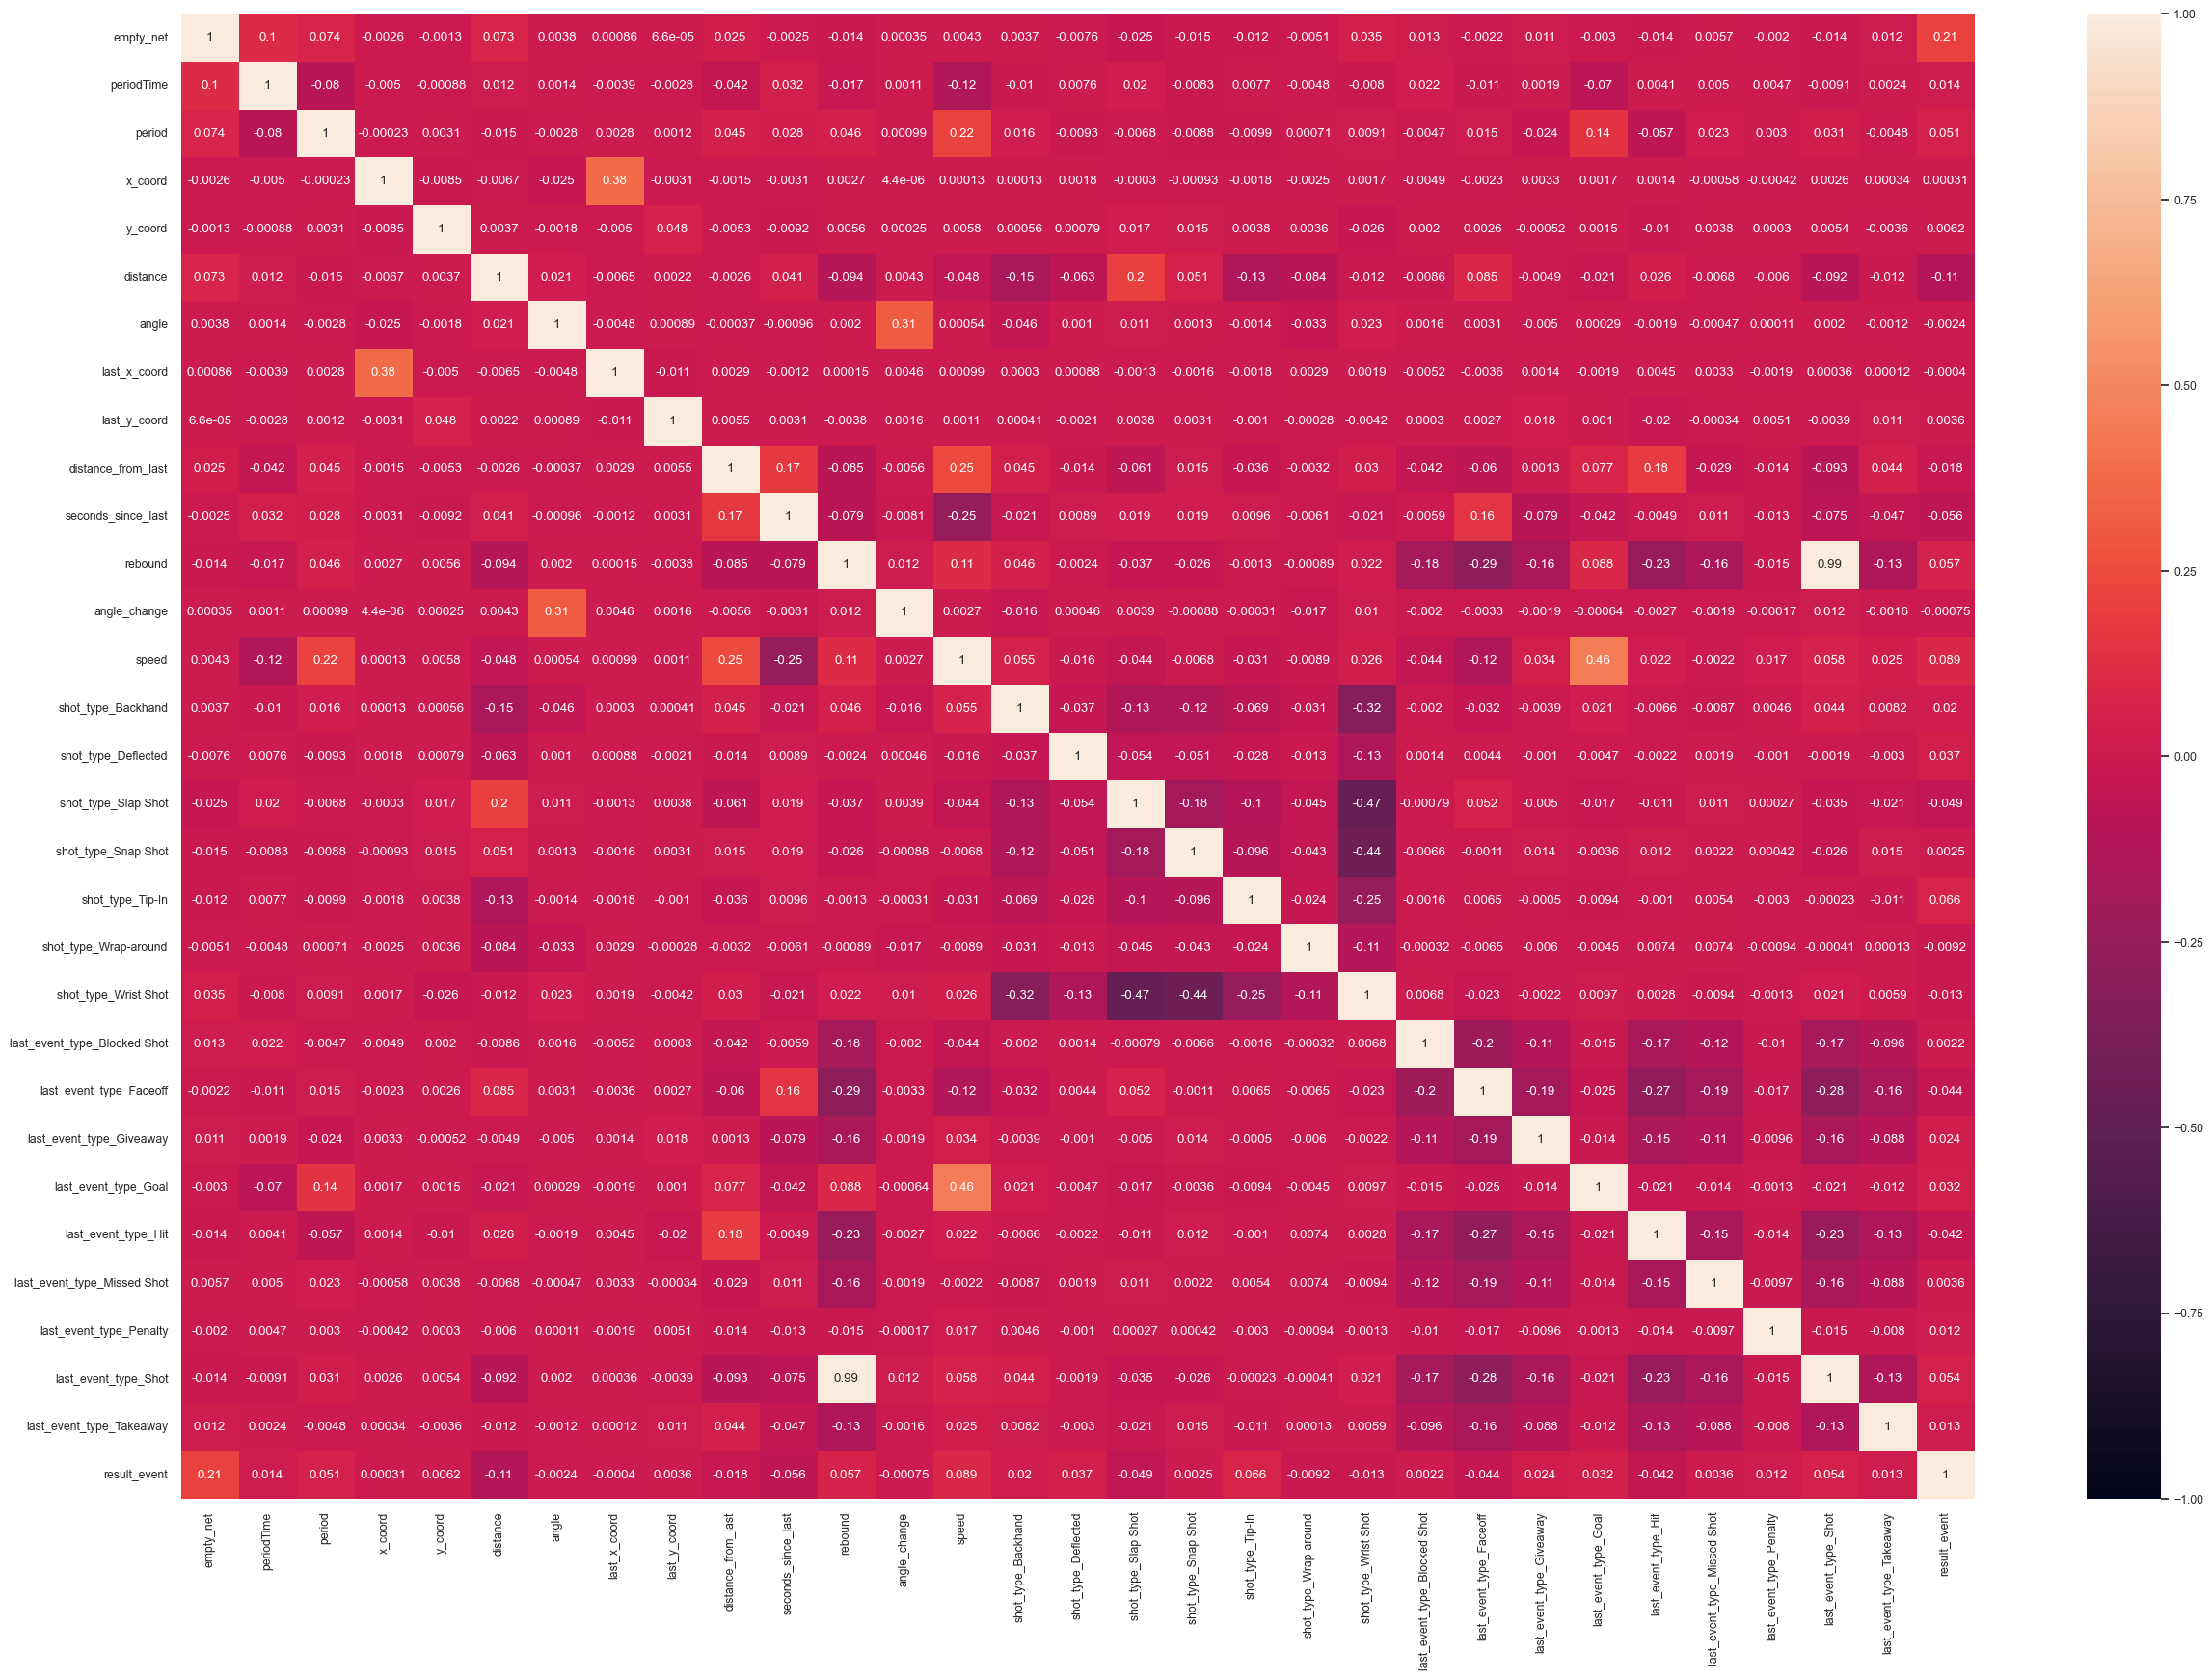

In [12]:
# Heatmap for feature variance
sns.set(font_scale=0.8)
plt.figure(figsize=(30,20))
sns.heatmap(df_train_total.corr(), vmax=1,vmin=-1, annot=True)

we can see that the rebound is highly correlated to the last event type. Which is logical, as the rebound is defined with the last event type.

We can ***suppress the last_event_type_Shot*** as it is less correlated with the target.

Also we can see that the variable that is the most correlated to the result_event is the 'empty_net'. Which seems logical as there are more chance that the shot is goal when the net is empty. For the other parameters the correlation is really small. Especially, we can see that x and y coordinates are not correlated to thee target when intuitively we would think there are. It's because the values are too precised and binning should be applied.

For now we don't perform this kind of preprocessing as the XGboost already handles it but for the next steps we should definitely take this into account.

### Features Selection

In [5]:
# consider all features except last_event_type_Shot

# list of features (here all of them)
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']
# preprocess
X, Y ,df_train_preprocessed,df_train_flag =  preprocess(df_train,features = list_features, standarize=True, drop_fts = ['last_event_type_Shot'])

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True, stratify=Y)

# concatenate the features and the target in one dataaframe
df_train_total = pd.concat([df_train_preprocessed, pd.DataFrame(Y,columns=['result_event'])], axis=1)

feature_names = np.array(df_train_preprocessed.columns.to_list())

#### Based on threshold

In [14]:
from sklearn.feature_selection import VarianceThreshold

# p (1-p) - Only for Boolean features
selector = VarianceThreshold(threshold=0.95)
features = selector.fit_transform(X)

print('Selected Support : ', selector.get_support())

variance_selected_fts = feature_names[selector.get_support()]
print('Selected Features: ', variance_selected_fts)

print('Selected Features shape: ', features.shape)

Selected Support :  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Selected Features:  ['empty_net' 'periodTime' 'period' 'x_coord' 'y_coord' 'distance' 'angle'
 'last_x_coord' 'last_y_coord' 'distance_from_last' 'seconds_since_last'
 'rebound' 'angle_change' 'speed' 'shot_type_Backhand'
 'shot_type_Deflected' 'shot_type_Slap Shot' 'shot_type_Snap Shot'
 'shot_type_Tip-In' 'shot_type_Wrap-around' 'shot_type_Wrist Shot'
 'last_event_type_Blocked Shot' 'last_event_type_Faceoff'
 'last_event_type_Giveaway' 'last_event_type_Goal' 'last_event_type_Hit'
 'last_event_type_Missed Shot' 'last_event_type_Penalty'
 'last_event_type_Takeaway']
Selected Features shape:  (321475, 29)


We can see that there are not really features with low variance. On this creataria we will keep all the features

#### SelectKBest (avec f score)

In [6]:
from sklearn.feature_selection import SelectKBest,f_classif,chi2
from sklearn.pipeline import Pipeline

In [7]:
def compute_metrics_all(y_true,y_preds):
    acc = metrics.accuracy_score(y_true,y_preds)
    recall = metrics.recall_score(y_true,y_preds,average='macro')
    precision = metrics.precision_score(y_true,y_preds,average='macro')
    f_score = metrics.f1_score(y_true,y_preds,average='macro')
    return acc,recall, precision,f_score

In [8]:
# Feature Selection
results = {}
for i in range(1, len(feature_names)+1):
    # define pipeline
    xgb_pipeline_select_k_best = Pipeline([('f_classif', SelectKBest(f_classif, k=i)),
                ('xgb', XGBClassifier(scale_pos_weight = 4))
                ])
    
    # fit_model
    xgb_pipeline_select_k_best.fit(X_train[:100000],y_train[:100000])
    y_val_pred,y_val_prob = predict_model(xgb_pipeline_select_k_best,X_val)
    acc,recall, precision,f_score = compute_metrics_all(y_val, y_val_pred)
    
    results[i] = [acc,recall, precision,f_score]



In [9]:
selet_k_best_results = pd.DataFrame.from_dict(results,orient='index',columns=['acc','recall', 'precision','f_score'])

In [10]:
selet_k_best_results 

,acc,recall,precision,f_score
1,0.910749,0.524211,0.955171,0.522719
2,0.889982,0.546945,0.604872,0.558200
3,0.878038,0.570623,0.599871,0.580988
4,0.878523,0.576539,0.605374,0.587138
5,0.868519,0.599147,0.605129,0.601987
6,0.867275,0.599233,0.603555,0.601314
7,0.871107,0.600753,0.609676,0.604894
8,0.870224,0.600444,0.608239,0.604093
9,0.868569,0.600780,0.606182,0.603360
10,0.869029,0.603115,0.608189,0.605548


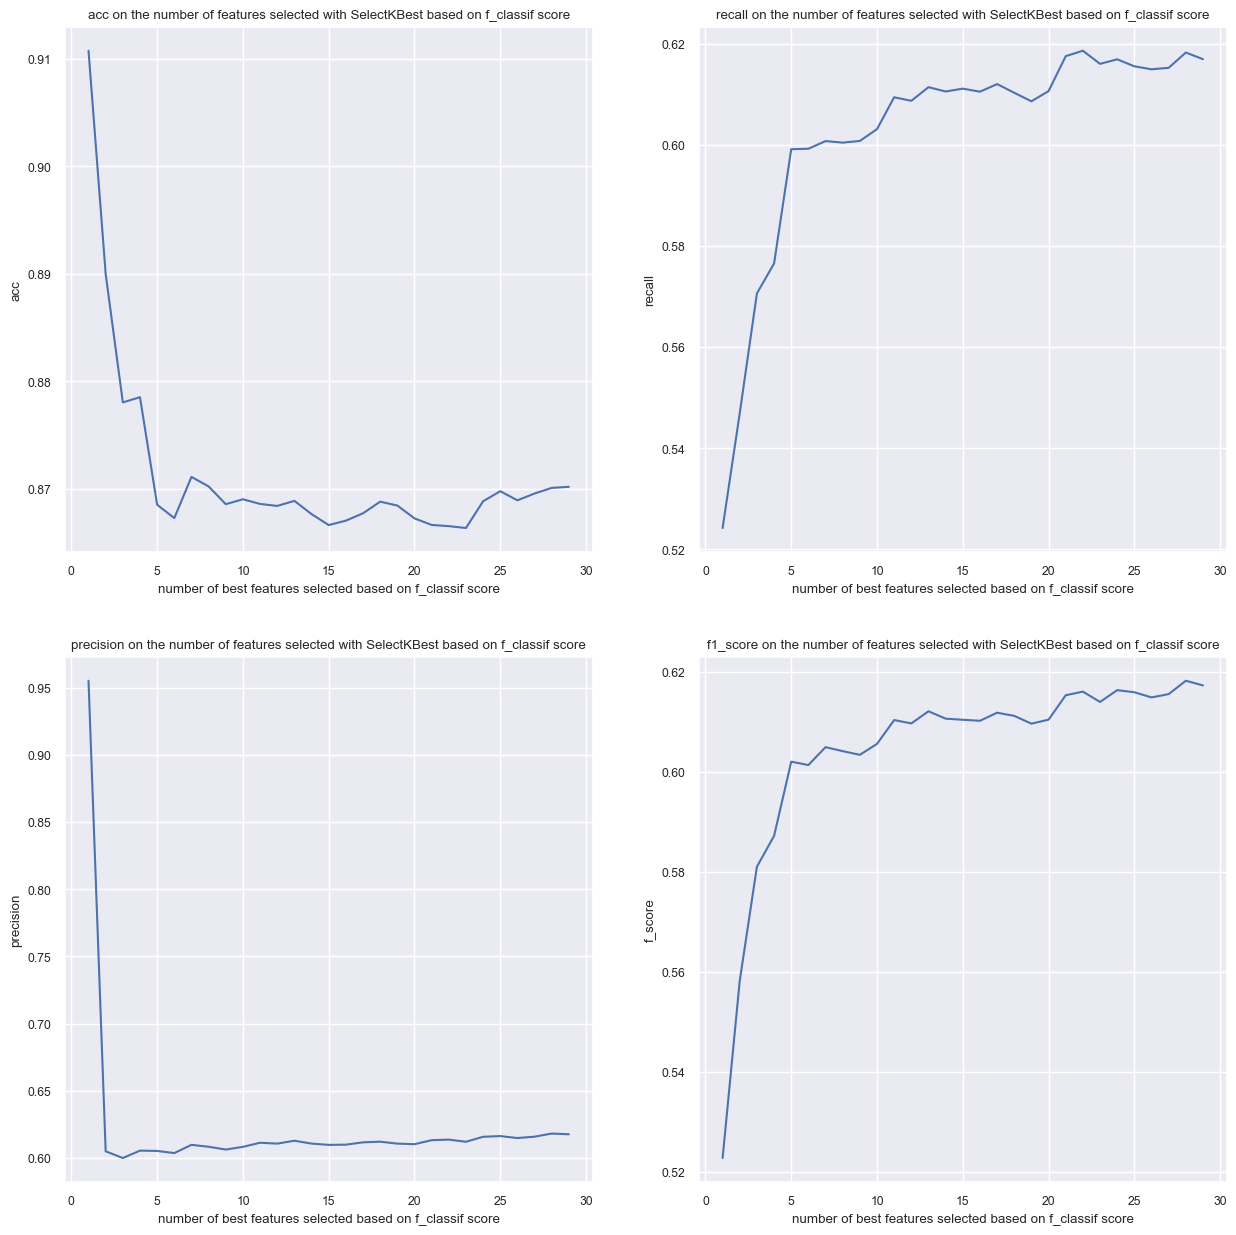

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.set(font_scale=0.8)

sns.lineplot(data=selet_k_best_results['acc'], ax=axs[0][0])
axs[0][0].set_title('acc on the number of features selected with SelectKBest based on f_classif score')
axs[0][0].set_xlabel('number of best features selected based on f_classif score')

sns.lineplot(data=selet_k_best_results['precision'], ax=axs[1][0])
axs[1][0].set_title('precision on the number of features selected with SelectKBest based on f_classif score')
axs[1][0].set_xlabel('number of best features selected based on f_classif score')

sns.lineplot(data=selet_k_best_results['recall'], ax=axs[0][1])
axs[0][1].set_title('recall on the number of features selected with SelectKBest based on f_classif score')
axs[0][1].set_xlabel('number of best features selected based on f_classif score')


sns.lineplot(data=selet_k_best_results['f_score'], ax=axs[1][1])
axs[1][1].set_title('f1_score on the number of features selected with SelectKBest based on f_classif score')
axs[1][1].set_xlabel('number of best features selected based on f_classif score')

#plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [13]:
from sklearn.svm import LinearSVC

from sklearn.feature_selection import SelectFromModel

# Select features based KBEST
xgb_pipeline_select_k_best= Pipeline([
  ('feature_selection', SelectKBest(f_classif, k=28)),
  ('classification', XGBClassifier(scale_pos_weight = 4))
])
xgb_pipeline_select_k_best.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(xgb_pipeline_select_k_best,X_val)
acc,recall, precision,f_score = compute_metrics_all(y_val, y_val_pred)
print(f'acc : {acc} \n recall : {recall} \n precision : {precision} \n f_score : {f_score}')


acc : 0.8716669362565168 
 recall : 0.6277027468837627 
 precision : 0.625120411017789 
 f_score : 0.6263898432049153


In [14]:
fKBest_selected_fts = feature_names[xgb_pipeline_select_k_best['feature_selection'].get_support()]
print('Selected Features: ', fKBest_selected_fts)

Selected Features:  ['empty_net' 'periodTime' 'period' 'y_coord' 'distance' 'angle'
 'last_x_coord' 'last_y_coord' 'distance_from_last' 'seconds_since_last'
 'rebound' 'angle_change' 'speed' 'shot_type_Backhand'
 'shot_type_Deflected' 'shot_type_Slap Shot' 'shot_type_Snap Shot'
 'shot_type_Tip-In' 'shot_type_Wrap-around' 'shot_type_Wrist Shot'
 'last_event_type_Blocked Shot' 'last_event_type_Faceoff'
 'last_event_type_Giveaway' 'last_event_type_Goal' 'last_event_type_Hit'
 'last_event_type_Missed Shot' 'last_event_type_Penalty'
 'last_event_type_Takeaway']


#### LASSO

In [23]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Select features based on Lasso
xgb_lasso = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(C=0.001, penalty="l1", dual=False))),
  ('classification', XGBClassifier(scale_pos_weight = 4))
])
xgb_lasso.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(xgb_pipeline_select_k_best,X_val)
acc,recall, precision,f_score = compute_metrics_all(y_val, y_val_pred)
print(f'acc : {acc} \n recall : {recall} \n precision : {precision} \n f_score : {f_score}')

print('Selected Support : ', xgb_lasso['feature_selection'].get_support())

lasso_selected_fts =feature_names[xgb_lasso['feature_selection'].get_support()]
print('Selected Features: ', lasso_selected_fts)

features = xgb_lasso['feature_selection'].transform(X)
print('Selected Features shape: ', features.shape)

acc : 0.8723886075476863 
 recall : 0.6270900174626204 
 precision : 0.6258640917541632 
 f_score : 0.6264721750059514
Selected Support :  [ True False  True False  True  True False False False  True  True  True
 False  True False  True False  True  True  True  True False  True  True
  True  True False  True  True]
Selected Features:  ['empty_net' 'period' 'y_coord' 'distance' 'distance_from_last'
 'seconds_since_last' 'rebound' 'speed' 'shot_type_Deflected'
 'shot_type_Snap Shot' 'shot_type_Tip-In' 'shot_type_Wrap-around'
 'shot_type_Wrist Shot' 'last_event_type_Faceoff'
 'last_event_type_Giveaway' 'last_event_type_Goal' 'last_event_type_Hit'
 'last_event_type_Penalty' 'last_event_type_Takeaway']
Selected Features shape:  (321475, 19)


#### Sequential Feed forward (forward et backward)

We saw that for the previous method 12 was a good number to select, thus for the sequential feed forward we will arbitrarly choose 12 as the number of features to select

In [24]:
'''
from sklearn.feature_selection import SequentialFeatureSelector
from time import time


tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    XGBClassifier(), n_features_to_select=12, direction="forward"
).fit(X_train[:50000],y_train[:50000])
toc_fwd = time()

print("Features selected by forward sequential selection: ", f"{feature_names[sfs_forward.get_support()]}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
'''

'\nfrom sklearn.feature_selection import SequentialFeatureSelector\nfrom time import time\n\n\ntic_fwd = time()\nsfs_forward = SequentialFeatureSelector(\n    XGBClassifier(), n_features_to_select=12, direction="forward"\n).fit(X_train[:50000],y_train[:50000])\ntoc_fwd = time()\n\nprint("Features selected by forward sequential selection: ", f"{feature_names[sfs_forward.get_support()]}")\nprint(f"Done in {toc_fwd - tic_fwd:.3f}s")\n'

In [25]:
'''
tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    XGBClassifier(), n_features_to_select=12, direction="backward"
).fit(X_train[:50000],y_train[:50000])
toc_bwd = time()

print("Features selected by backward sequential selection: ", f"{feature_names[sfs_backward.get_support()]}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")
'''

'\ntic_bwd = time()\nsfs_backward = SequentialFeatureSelector(\n    XGBClassifier(), n_features_to_select=12, direction="backward"\n).fit(X_train[:50000],y_train[:50000])\ntoc_bwd = time()\n\nprint("Features selected by backward sequential selection: ", f"{feature_names[sfs_backward.get_support()]}")\nprint(f"Done in {toc_bwd - tic_bwd:.3f}s")\n'

### Comparing the features selection methods (saving them on comet)

In [26]:
# shap features selected
shap_selected_fts = ['y_coord','distance','speed','x_coord',\
    'last_x_coord','period', 'periodTime', 'empty_net',\
        'shot_type_Wrist Shot', 'distance_from_last', 'seconds_since_last','shot_type_Tip-In']

# list of features (here all of them)
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

In [27]:
variance_selected_fts

array(['empty_net', 'periodTime', 'period', 'x_coord', 'y_coord',
       'distance', 'angle', 'last_x_coord', 'last_y_coord',
       'distance_from_last', 'seconds_since_last', 'rebound',
       'angle_change', 'speed', 'shot_type_Backhand',
       'shot_type_Deflected', 'shot_type_Slap Shot',
       'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around',
       'shot_type_Wrist Shot', 'last_event_type_Blocked Shot',
       'last_event_type_Faceoff', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Penalty',
       'last_event_type_Takeaway'], dtype='<U28')

In [28]:
list_kept_fts_per_method = [np.concatenate((variance_selected_fts, np.array(['last_event_type_Shot']))), shap_selected_fts, variance_selected_fts, lasso_selected_fts, fKBest_selected_fts]
list_kept_fts_method_names = ['all_fts','shap', 'variance','lasso', 'fKBest']

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/princesslove/itf-6758-team-4/5a2d2a2cc121456389eecf91a5601723

COMET WARNING: Converting metric value ''question_XGB_all_fts'' into a string using str(), resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/5a2d2a2cc121456389eecf91a5601723
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.6274423653178425
COMET INFO:     Accuracy   : 0.8728116562356132
COMET INFO:     Precision  : 0.6266596750814606
COMET INFO:     Recall     : 0.6274423653178425
COMET INFO:     f_score    : 0.627049045044769
COMET

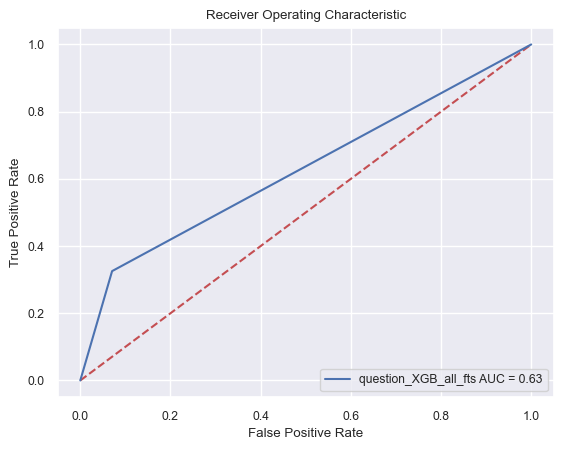

<Figure size 640x480 with 0 Axes>

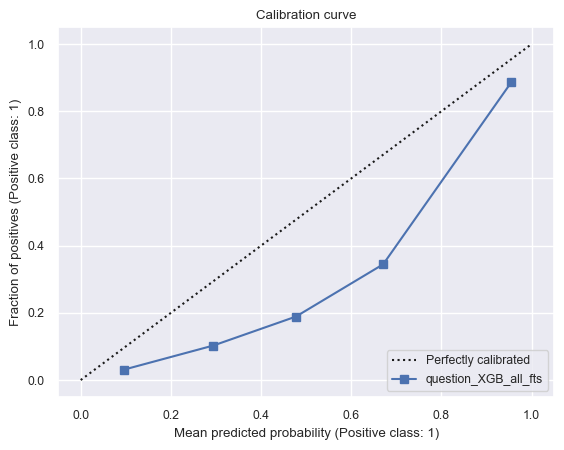

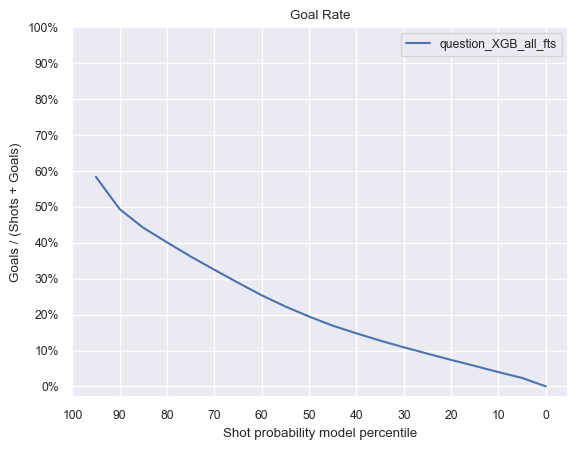

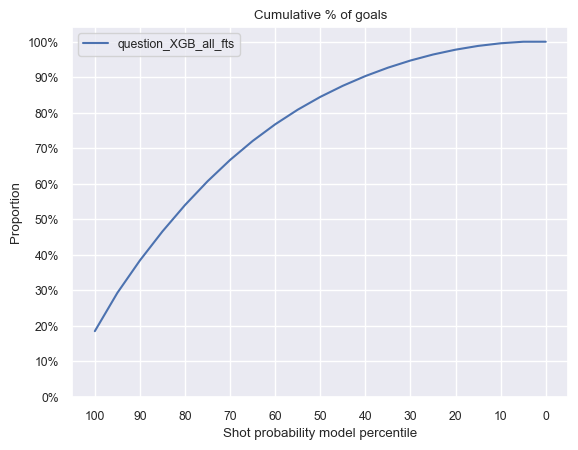

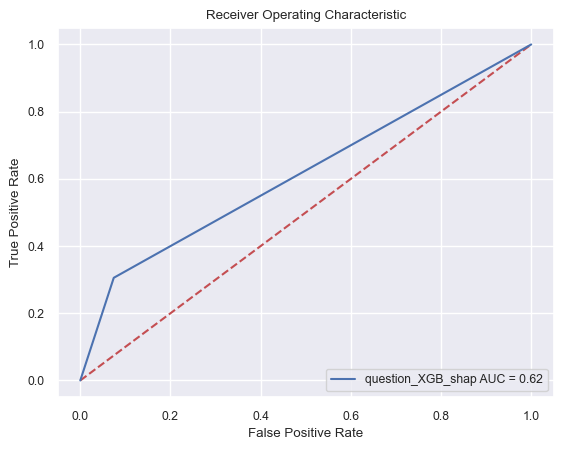

<Figure size 640x480 with 0 Axes>

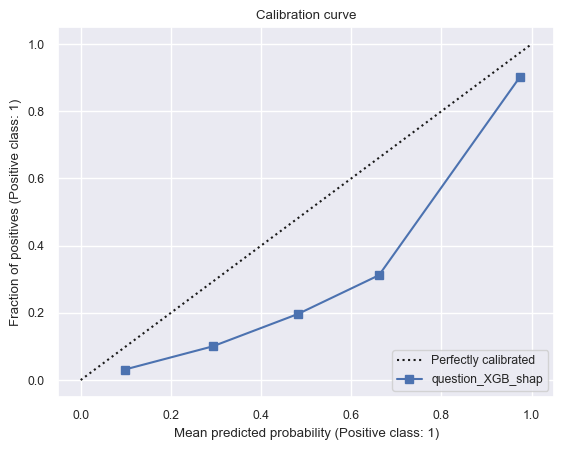

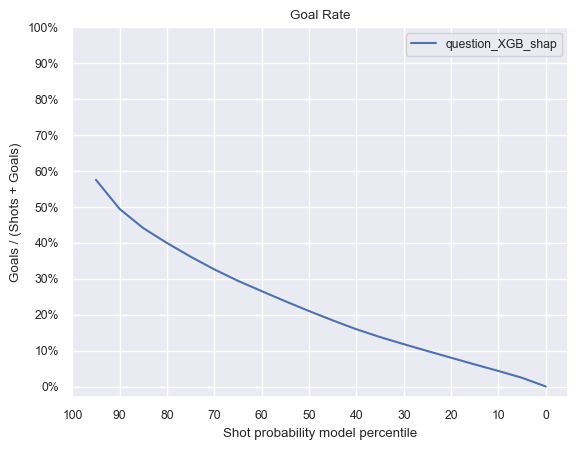

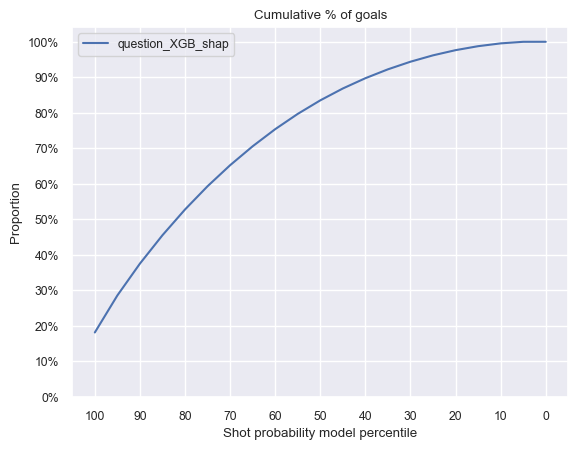

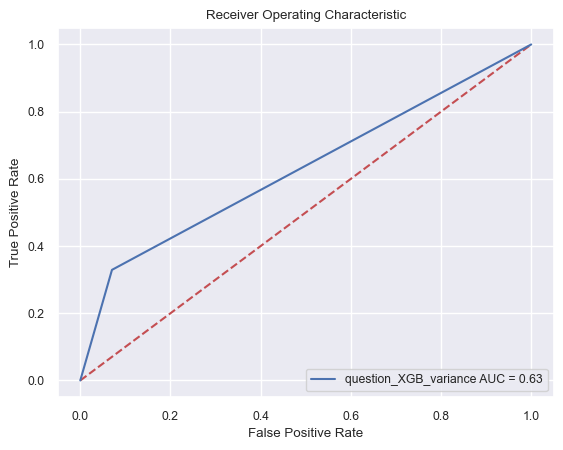

<Figure size 640x480 with 0 Axes>

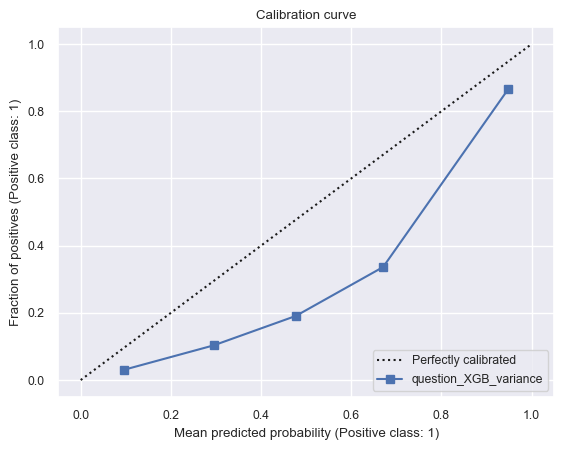

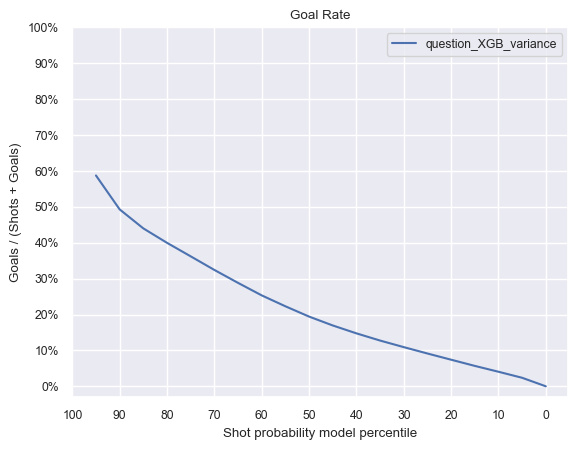

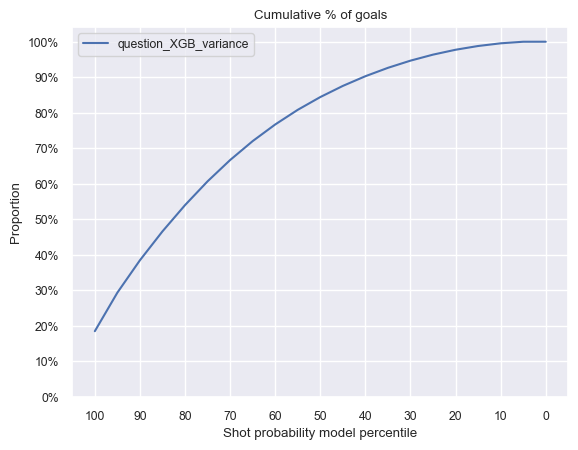

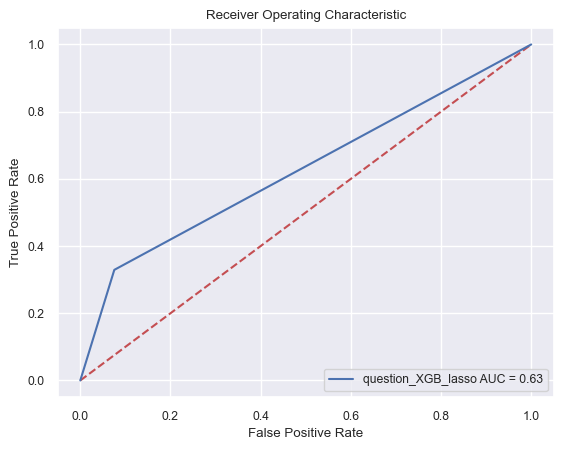

<Figure size 640x480 with 0 Axes>

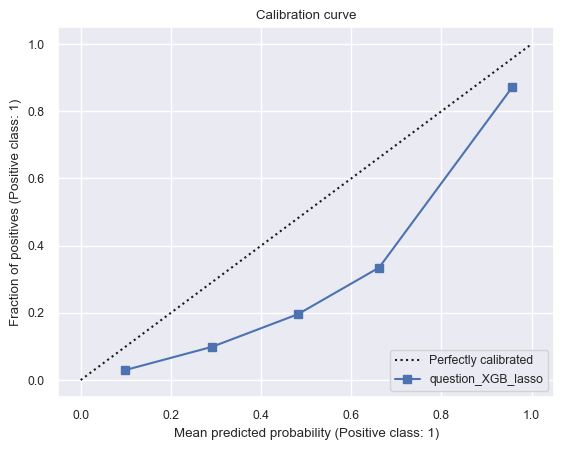

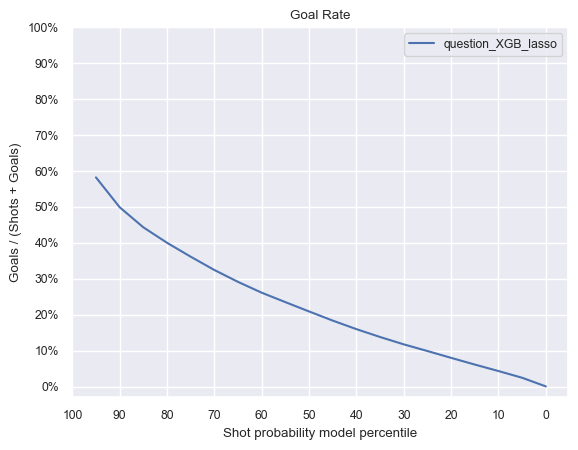

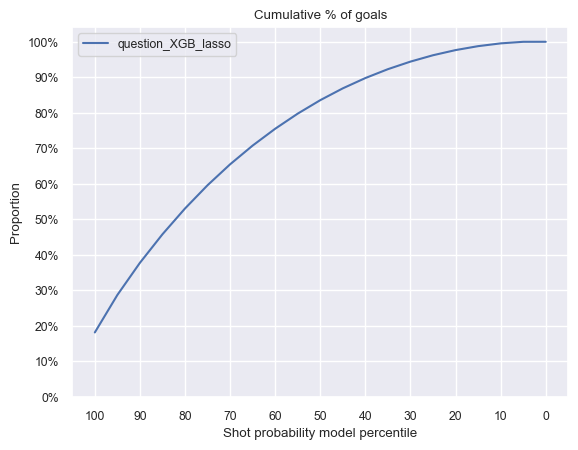

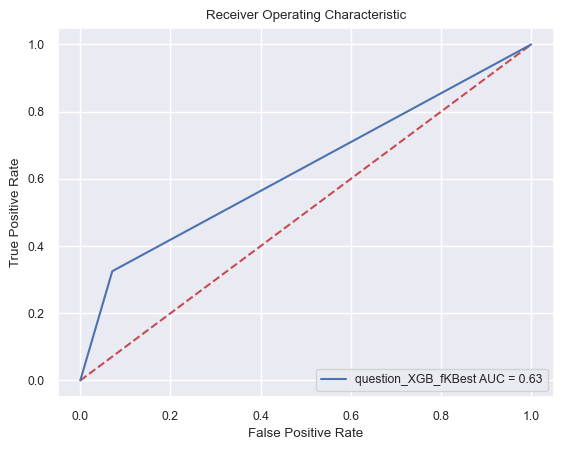

<Figure size 640x480 with 0 Axes>

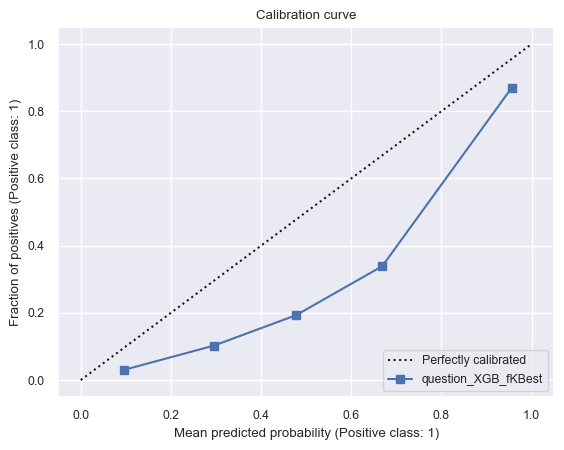

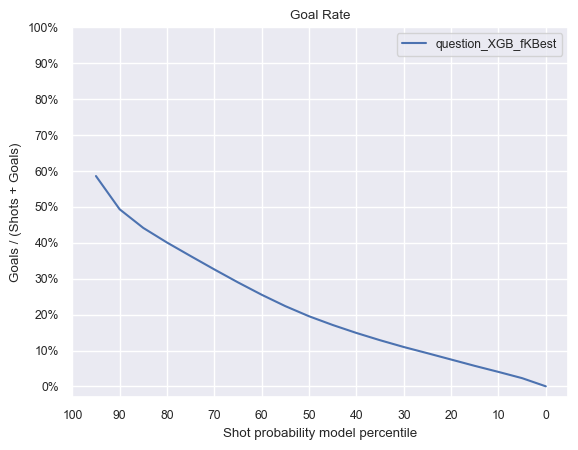

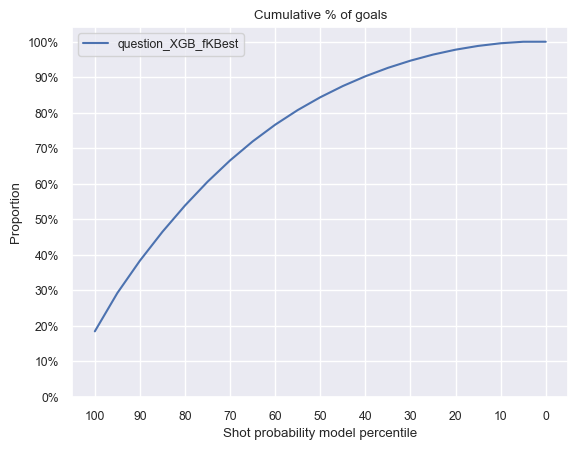

In [29]:
all_results_per_method = {}
for kept_fts_method, selection_method in zip(list_kept_fts_per_method,list_kept_fts_method_names) : 
    # preprocess
    X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True, keep_fts = kept_fts_method)

    # train/test split
    X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)

    # define and train model
    model = XGBClassifier(scale_pos_weight = 4)
    
    # fit_model
    model.fit(X_train,y_train)
    y_val_pred,y_val_prob = predict_model(model,X_val)

    name_experiment = f"question_XGB_{selection_method}"
    model_dir = "XGB"
    
    save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = False )
    
    all_results_per_method[selection_method] = [y_val_pred,y_val_prob]

In [30]:
y_val_pred_list = [v[0] for v in all_results_per_method.values()]
y_val_prob_list = [v[1] for v in all_results_per_method.values()]
model_names = all_results_per_method.keys()

compute_metrics(y_val,y_val_pred_list,model_names)

,model_name,Accuracy,Recall,Precision,f_score
0,all_fts,0.872812,0.627442,0.626660,0.627049
1,shap,0.867623,0.615660,0.613387,0.614504
2,variance,0.873409,0.629437,0.628521,0.628976
3,lasso,0.868718,0.626849,0.620622,0.623604
4,fKBest,0.872389,0.627090,0.625864,0.626472


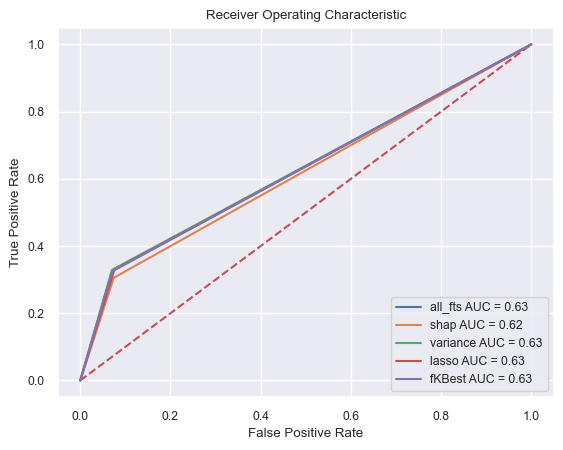

<Figure size 640x480 with 0 Axes>

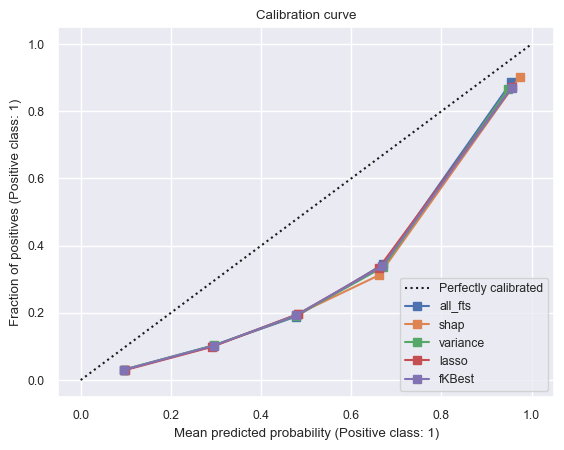

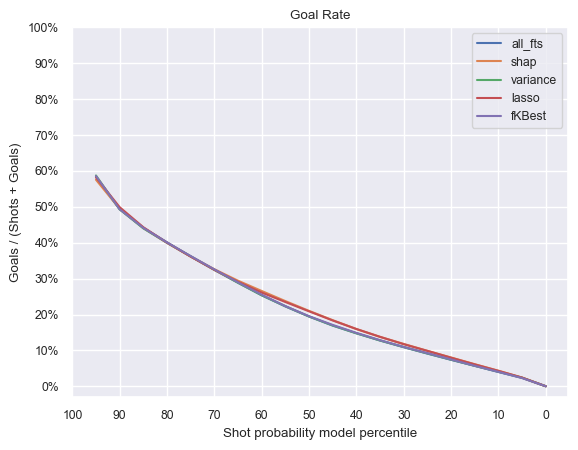

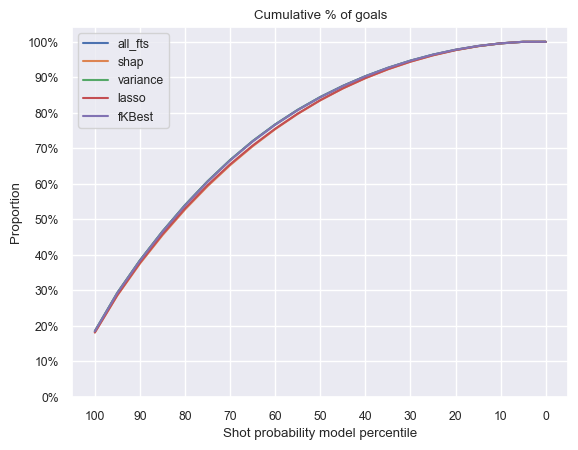

In [31]:
a,_ = log_ROC(y_val,y_val_pred_list,model_names=model_names)
b = log_Calibration(y_val,y_val_prob_list,model_names=model_names)
c = log_GoalRate(y_val_prob_list,model_names=model_names)
d = log_Cumulative(y_val_prob_list,model_names=model_names)

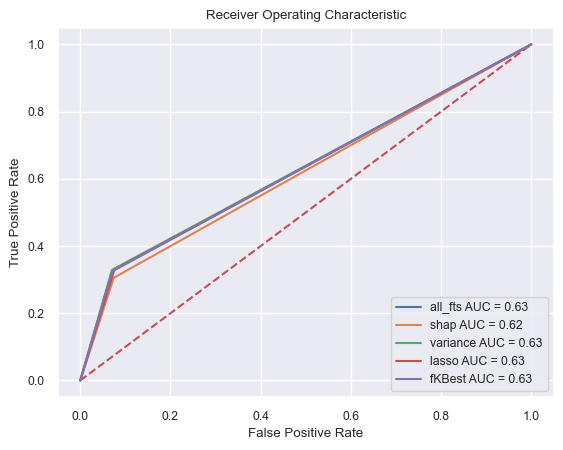

In [32]:
a

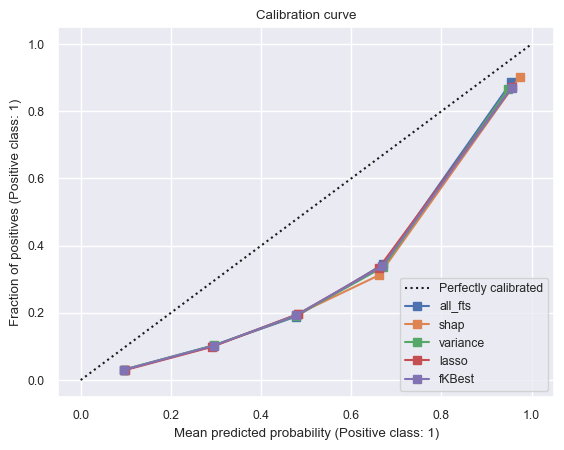

In [33]:
b

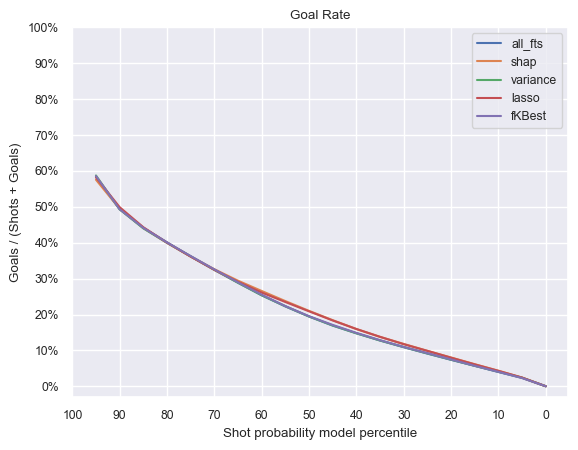

In [34]:
c

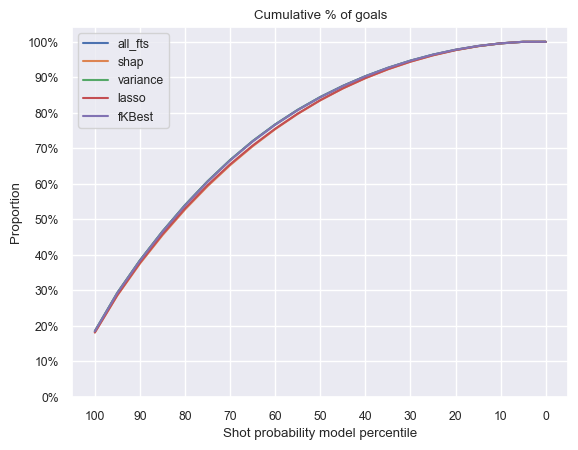

In [35]:
d

### Computing Grid Search on the selected features and saving the models

In [36]:
final_features_selected = variance_selected_fts

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
              'scale_pos_weight' : [2,3,4,5,6,7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'max_delta_step' : [1,2,3,4,5,6,7,8,9,10],
              'min_child_weight': [1, 5, 10],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'lambda':[0.4, 0.6,0.8,1],
            'alpha':[0, 0.2,0.4,0.6],
            }


# question 5.2

list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
#X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True)
# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True, keep_fts = final_features_selected)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)

# define and train model
model = XGBClassifier(objective='binary:logistic',
                        predictor='cpu_predictor',
                        tree_method = 'hist')

# performing Random Search
folds = 5
param_comb = 100



skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
#rskf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=3, random_state = 42)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb, scoring='f1_macro', n_jobs=-1, cv=skf, verbose=3, random_state=42 )

# Here we go
start_time = time.time() # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
print(time.time() - start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 2/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2, reg_lambda=0, scale_pos_weight=6, subsample=0.8;, score=0.621 total time=  50.1s
[CV 4/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2, reg_lambda=0, scale_pos_weight=6, subsample=0.8;, score=0.618 total time=  50.4s
[CV 3/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2, reg_lambda=0, scale_pos_weight=6, subsample=0.8;, score=0.613 total time=  50.5s
[CV 1/5] END alpha=0.6, colsample_bytree=0.6, gamma=0.8, lambda=0.4, learning_rate=0.01, max_delta_step=2, max_depth=14, min_child_weight=5, n_estimators=100, reg_alpha=0.2

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV 3/5] END alpha=0.6, colsample_bytree=0.8, gamma=3.2, lambda=1, learning_rate=0.5, max_delta_step=6, max_depth=5, min_child_weight=10, n_estimators=65, reg_alpha=0.1, reg_lambda=12.8, scale_pos_weight=6, subsample=0.8;, score=0.599 total time=   5.5s
[CV 5/5] END alpha=0.2, colsample_bytree=0.8, gamma=3.2, lambda=1, learning_rate=0.01, max_delta_step=3, max_depth=9, min_child_weight=10, n_estimators=130, reg_alpha=6.4, reg_lambda=200, scale_pos_weight=3, subsample=0.8;, score=0.604 total time=  11.3s
[CV 4/5] END alpha=0.6, colsample_bytree=0.8, gamma=3.2, lambda=1, learning_rate=0.5, max_delta_step=6, max_depth=5, min_child_weight=10, n_estimators=65, reg_alpha=0.1, reg_lambda=12.8, scale_pos_weight=6, subsample=0.8;, score=0.604 total time=   5.3s
[CV 5/5] END alpha=0.6, colsample_bytree=0.8, gamma=3.2, lambda=1, learning_rate=0.5, max_delta_step=6, max_depth=5, min_child_weight=10, n_estimators=65, reg_alpha=0.1, reg_lambda=12.8, scale_pos_weight=6, subsample=0.8;, score=0.599 to

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/princesslove/itf-6758-team-4/38505bd6308c472084e1f4d53f7d650a

COMET WARNING: Converting metric value ''question5.3_grid_search_fts_selected'' into a string using str(), resulting string might be invalid
COMET INFO: Successfully registered 'question5-3-grid-search-fts-selected-model', version '1.0.0' in workspace 'princesslove'


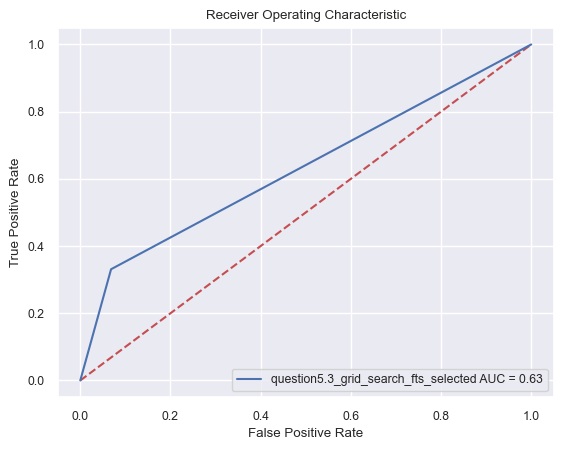

<Figure size 640x480 with 0 Axes>

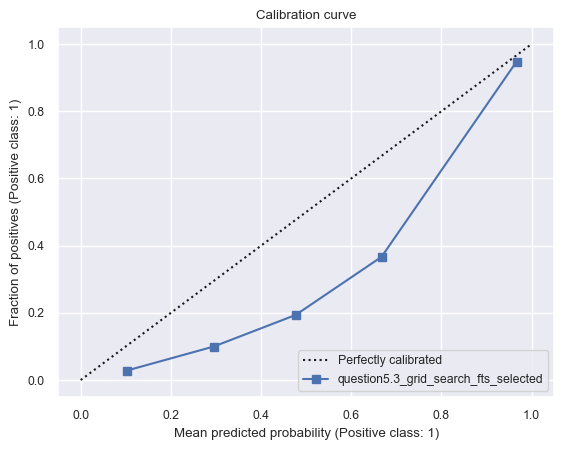

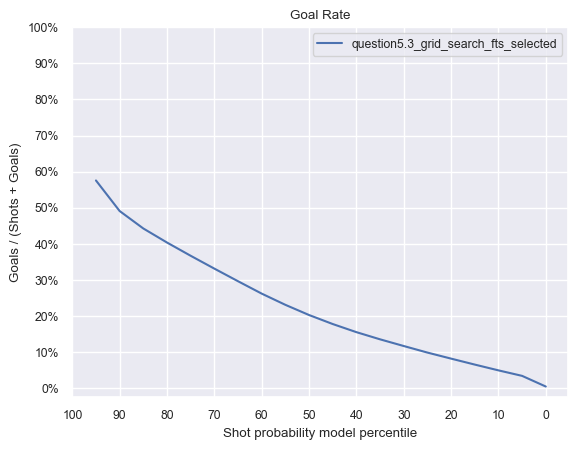

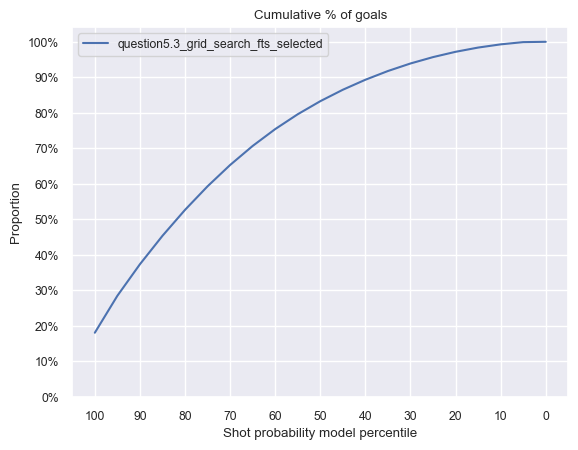

In [37]:
model.set_params(**random_search.best_params_)
# fit model 
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

name_experiment = "question5.3_grid_search_fts_selected"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = True)